### Saves Images on click

In [14]:
import cv2

cam = cv2.VideoCapture(0)

if not cam.isOpened():
    print("Error: Camera not opened")
    exit()

cv2.namedWindow("Camera")

counter = 10000
current_frame = None

def mouse_click(event, x, y, flags, param):
    global counter, current_frame
    if event == cv2.EVENT_LBUTTONDOWN:
        counter += 1
        filename = f"data/captured_{counter}.png"
        cv2.imwrite(filename, current_frame)
        print(f"Saved {filename}")

cv2.setMouseCallback("Camera", mouse_click)

while True:
    ret, frame = cam.read()
    if not ret:
        print("Failed to grab frame")
        break

    current_frame = frame.copy()
    cv2.imshow("Camera", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cam.release()
cv2.destroyAllWindows()


Saved data/captured_10001.png


### Taking Pictures Every 5s

In [13]:
import cv2
import time

cam = cv2.VideoCapture(0)

# Warm up the camera
time.sleep(2)

c = 0

while True:
    ret, frame = cam.read()

    if not ret:
        print("Failed to capture image.")
        break

    c += 1
    filename = f"data/captured_image_{c}.png"

    cv2.imshow("Captured", frame)
    cv2.imwrite(filename, frame)
    print(f"Saved {filename}")

    # Wait 5 seconds, exit if 'q' is pressed
    if cv2.waitKey(5000) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()
cam.release()


Saved data/captured_image_1.png


### Importing Libraries

In [1]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [29]:

drawing_utils = mp.solutions.drawing_utils
drawing_styles = mp.solutions.drawing_styles

def run_filter_with_mediapipe_model(mediapipe_model, mediapipe_based_filter):
    """Run a media pipe model on each video frame grabbed by the webcam and draw results on it

    Args:
        mediapipe_model (): A mediapipe model
        mediapipe_based_filter (): a function to draw model results on frame

    Returns:
        np.ndarray, mediapipe model result
    """
    cap = cv2.VideoCapture(0)
    cv2.namedWindow("Face Swap",cv2.WINDOW_NORMAL)
    try:
        with mediapipe_model as model:
            while cap.isOpened():
                success, image = cap.read()

                if not success:
                    print("Ignoring empty camera frame.")
                    continue     # If loading a video, use 'break' instead of 'continue'.

                # Flip the image horizontally for a later selfie-view display, and convert
                # the BGR image to RGB.
                image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)

                try:
                    results = model.process(image)
                except Exception:
                    results = None

                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

                if results and results.pose_landmarks:
                    result_image = mediapipe_based_filter(image, results)
                else:
                    result_image = image

                cv2.imshow('Face Swap', result_image)

                if cv2.waitKey(5) & 0xFF == ord('q'):
                    break
                    
    finally:
        cap.release()
        cv2.destroyAllWindows()
    
    return image, results

In [30]:
# see https://google.github.io/mediapipe/solutions/holistic#python-solution-api
Holistic = mp.solutions.holistic.Holistic

def draw_holistic_results(image, results, show_hands=True, show_face=False, show_pose=True):
    if show_hands:
        drawing_utils.draw_landmarks(
            image,
            results.left_hand_landmarks,
            mp.solutions.holistic.HAND_CONNECTIONS,
            connection_drawing_spec=drawing_styles.get_default_hand_connections_style()
        )

        drawing_utils.draw_landmarks(
            image,
            results.right_hand_landmarks,
            mp.solutions.holistic.HAND_CONNECTIONS,
            connection_drawing_spec=drawing_styles.get_default_hand_connections_style()
        )

    if show_face:
        drawing_utils.draw_landmarks(
            image,
            results.face_landmarks,
            mp.solutions.holistic.FACEMESH_CONTOURS,
            landmark_drawing_spec=drawing_utils.DrawingSpec(thickness=0, circle_radius=0, color=(255, 255, 255)),
            connection_drawing_spec=drawing_styles.get_default_face_mesh_contours_style()
        )

    if show_pose:
        drawing_utils.draw_landmarks(
            image,
            results.pose_landmarks,
            mp.solutions.holistic.POSE_CONNECTIONS,
            landmark_drawing_spec=drawing_styles.get_default_pose_landmarks_style()
        )
    return image

In [31]:
last_image, last_results = run_filter_with_mediapipe_model(
    mediapipe_model=Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5),
    mediapipe_based_filter=draw_holistic_results
)

In [ ]:
Holistic = mp.solutions.holistic.Holistic
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def extract_landmarks(landmarks):
    return np.array([[l.x, l.y] for l in landmarks],dtype=np.float32)

### Construction of the Dataset (0 = down, 1 = Up)

In [ ]:
import os
import pickle
dataset = []
target = []
folder_path_up = "haut/" 
folder_path = folder_path_up
all_files = os.listdir(folder_path)  # lists files and folders
files_only = [f for f in all_files if os.path.isfile(os.path.join(folder_path, f))]
counter = 0
L = len(files_only)
model = Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)

for f in files_only:
    counter += 1
    print(100*counter/L,end="\r")
    image = plt.imread(folder_path+f)
    img_model = (image[..., :3] * 255).astype(np.uint8)
    model = Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)
    results = model.process(img_model)
    if results.pose_landmarks is not None:
        ldk = extract_landmarks(results.pose_landmarks.landmark)
        ldk_temp = extract_landmarks(results.pose_landmarks.landmark).flatten()
        dataset.append(ldk_temp)

with open('dataset_up.pkl', 'wb') as file:  # 'wb' = write binary
    pickle.dump(dataset, file)

In [7]:
dataset.shape

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
import pickle
import os 
with open('dataset_up.pkl', 'rb') as file:  # 'rb' = read binary
    dataset = pickle.load(file)
size_up = len(dataset)
folder_path_down = "bas/" 
folder_path = folder_path_down
all_files = os.listdir(folder_path)  # lists files and folders
files_only = [f for f in all_files if os.path.isfile(os.path.join(folder_path, f))]
counter = 0
L2 = len(files_only)
for f in files_only:
    counter += 1
    print(100*counter/L2,end="\r")
    image = plt.imread(folder_path+f)
    img_model = (image[..., :3] * 255).astype(np.uint8)
    model = Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)
    results = model.process(img_model)
    if results.pose_landmarks is not None:
        ldk = extract_landmarks(results.pose_landmarks.landmark)
        ldk_temp = extract_landmarks(results.pose_landmarks.landmark).flatten()
        dataset.append(ldk_temp)



AttributeError: 'list' object has no attribute 'shape'

In [8]:
dataset = np.array(dataset)
target = np.array(list(np.ones(size_up))+list(np.zeros(dataset.shape[0] - size_up)))
target = np.array(target)
data = np.concatenate((dataset,np.reshape(target,[len(target),1])),axis=1)

In [9]:
columns = []
for col in range(int(dataset.shape[1]/2)):
    columns.append(f"x{col}")
    columns.append(f"y{col}")
columns.append("target")
import pandas as pd
df = pd.DataFrame(data=data,columns=columns,index=range(len(dataset)))

In [10]:
df

,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,...,y28,x29,y29,x30,y30,x31,y31,x32,y32,target
0,0.394474,0.545781,0.381763,0.524122,0.384034,0.520183,0.386281,0.515495,0.376742,0.524121,...,0.414985,0.961311,0.493354,0.853787,0.393870,0.936893,0.596360,0.827120,0.459797,1.0
1,0.347058,0.506565,0.337884,0.480893,0.340595,0.476936,0.343649,0.472280,0.334599,0.483857,...,0.622462,0.995329,0.644413,0.980278,0.615301,0.956545,0.708013,0.935291,0.683986,1.0
2,0.421925,0.365478,0.412931,0.357425,0.413167,0.352227,0.413356,0.346921,0.411812,0.370187,...,0.354144,0.821534,0.349835,0.801479,0.342128,0.808728,0.412713,0.791669,0.403499,1.0
3,0.417756,0.338324,0.409151,0.326722,0.409508,0.322400,0.409948,0.317097,0.408196,0.340370,...,0.326704,0.858249,0.314094,0.813136,0.323511,0.879437,0.382655,0.810407,0.374478,1.0
4,0.420651,0.395017,0.412873,0.384113,0.412938,0.378140,0.413133,0.372694,0.411932,0.397265,...,0.335099,0.858835,0.324589,0.836154,0.327149,0.876916,0.373488,0.824137,0.371892,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,0.176868,0.515265,0.188942,0.508023,0.189073,0.508092,0.189261,0.508139,0.190576,0.503098,...,0.585112,0.827654,0.614664,0.825104,0.576438,0.825982,0.672501,0.813406,0.633669,0.0
189,0.157913,0.487739,0.143649,0.473703,0.143697,0.477383,0.143692,0.482253,0.148137,0.459739,...,0.561693,0.927785,0.636963,0.906138,0.554398,0.903729,0.739754,0.898433,0.644027,0.0
190,0.194949,0.498894,0.184350,0.493428,0.184091,0.498112,0.181218,0.507511,0.185453,0.476569,...,0.564535,0.918056,0.626454,0.904855,0.552727,0.899660,0.737396,0.908385,0.613349,0.0
191,0.872035,0.640834,0.880280,0.619367,0.881142,0.618744,0.881833,0.618068,0.873676,0.615149,...,0.561646,0.191166,0.452388,0.099483,0.536709,0.207537,0.561391,0.142288,0.661007,0.0


### Saving the Dataset

In [11]:

df.to_pickle("data_df")

### Loading the Dataset

In [12]:
df = pd.read_pickle("data_df")

### Train/Test Splitting

In [35]:
from sklearn.model_selection import train_test_split
X = df[df.columns[:-1]]
y = df[df.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42)


### RF Classifier (Accuracy = 93%)

In [36]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
params = {'n_estimators': range(100,500,100),
          'max_depth' : range(2,10,2)}
cv = RandomizedSearchCV(rf,params,verbose=1,scoring="accuracy",n_jobs=-1)
history = cv.fit(X_train,y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
pd.DataFrame(history.cv_results_)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.171707,0.015995,0.004293,0.003454,200,3,"{'n_estimators': 200, 'max_depth': 3}",0.863636,0.727273,0.952381,0.809524,0.761905,0.822944,0.079333,4
1,0.273796,0.017001,0.018501,0.004152,300,3,"{'n_estimators': 300, 'max_depth': 3}",0.863636,0.681818,0.952381,0.809524,0.761905,0.813853,0.091454,7
2,0.379986,0.017808,0.017705,0.002957,400,3,"{'n_estimators': 400, 'max_depth': 3}",0.863636,0.636364,0.952381,0.809524,0.761905,0.804762,0.105333,8
3,0.196660,0.021953,0.009879,0.006318,200,5,"{'n_estimators': 200, 'max_depth': 5}",0.863636,0.681818,0.952381,0.809524,0.809524,0.823377,0.087961,3
4,0.281563,0.029105,0.018674,0.003678,300,5,"{'n_estimators': 300, 'max_depth': 5}",0.863636,0.772727,0.952381,0.809524,0.809524,0.841558,0.062545,1
5,0.361433,0.013258,0.018070,0.002077,400,5,"{'n_estimators': 400, 'max_depth': 5}",0.863636,0.727273,0.952381,0.809524,0.809524,0.832468,0.074121,2
6,0.215126,0.038613,0.013485,0.009026,200,7,"{'n_estimators': 200, 'max_depth': 7}",0.863636,0.727273,0.952381,0.809524,0.761905,0.822944,0.079333,4
7,0.295569,0.006710,0.015804,0.006298,300,7,"{'n_estimators': 300, 'max_depth': 7}",0.863636,0.727273,0.952381,0.809524,0.761905,0.822944,0.079333,4
8,0.540124,0.117721,0.033092,0.011583,400,7,"{'n_estimators': 400, 'max_depth': 7}",0.863636,0.636364,0.952381,0.809524,0.761905,0.804762,0.105333,8


In [37]:
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier(**history.best_params_)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.9655172413793104

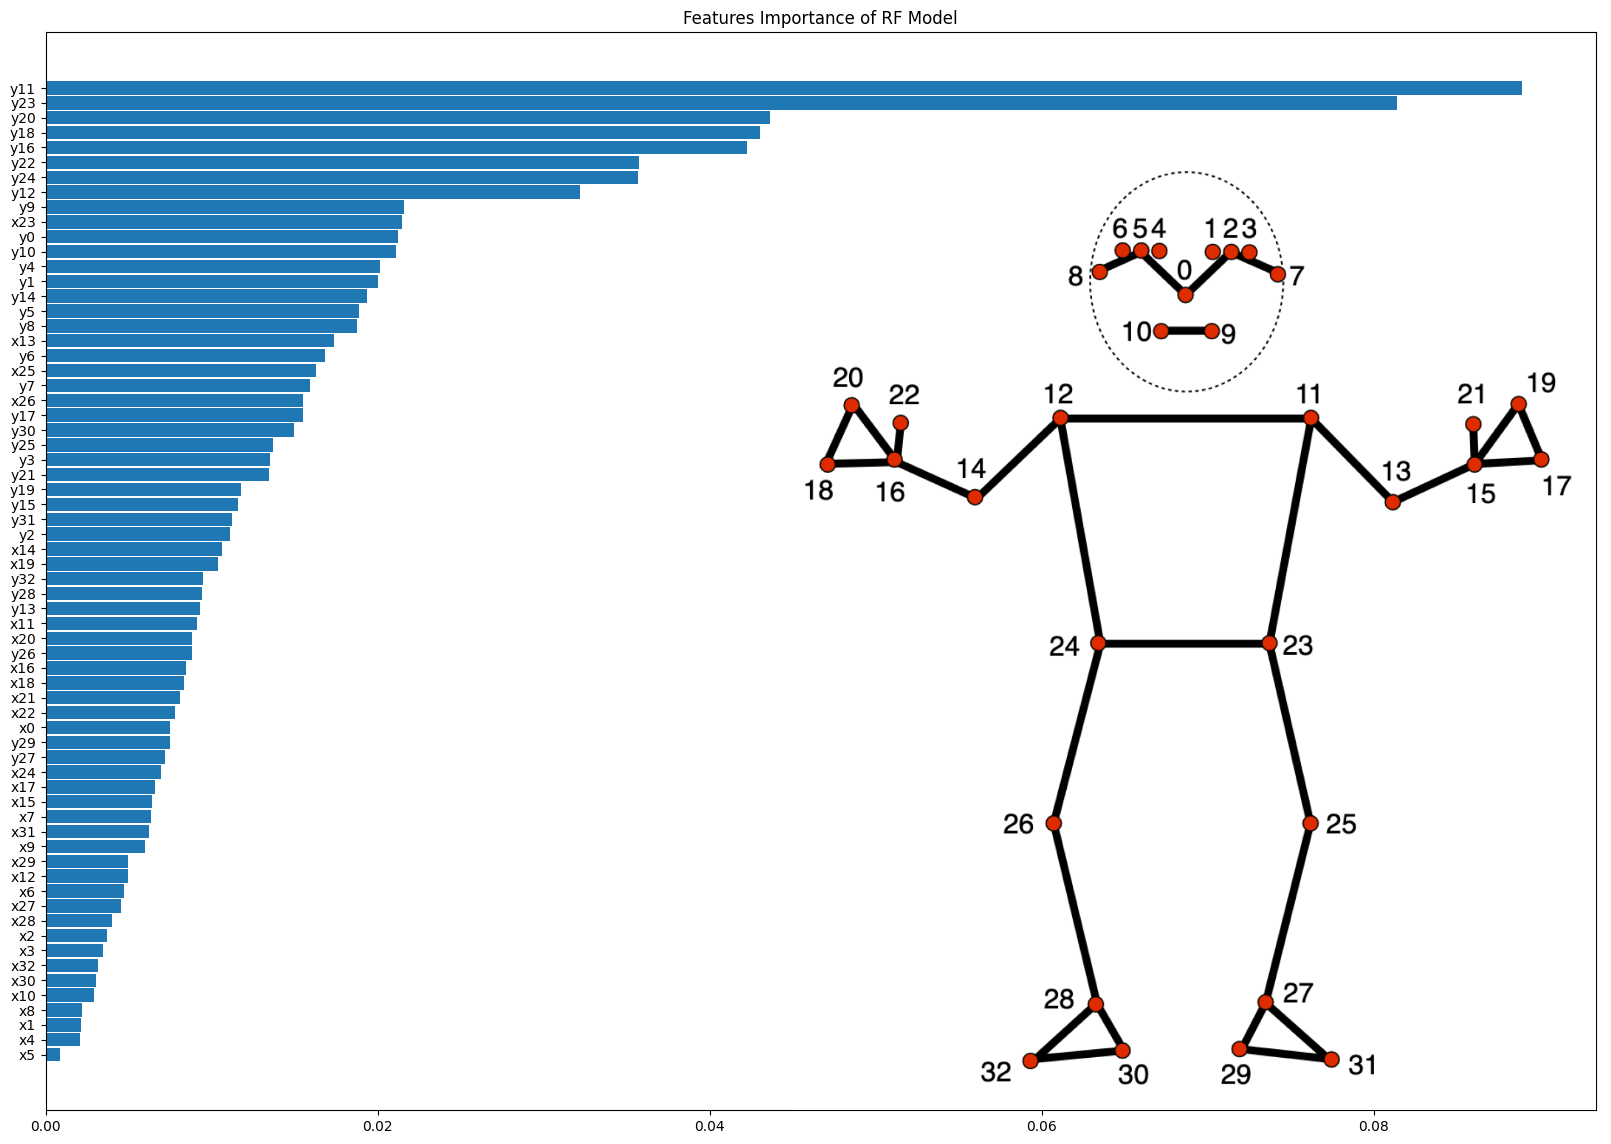

In [16]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
from PIL import Image
ind= np.argsort(rf.feature_importances_)
fig,ax = plt.subplots(figsize=[20,14])
ax.barh(y=1*np.array(range(len(rf.feature_importances_))),width= rf.feature_importances_[ind],height=.9)
ax.set_yticks(1*np.array(range(len(rf.feature_importances_))))
ax.set_yticklabels(df.columns[ind])
ax.set_title("Features Importance of RF Model")


img = Image.open("pose_landmarks_index.png")  # Replace with your file path

# Use OffsetImage and AnnotationBbox to place it
imagebox = OffsetImage(img, zoom=0.4)  # adjust zoom as needed
ab = AnnotationBbox(imagebox, (1, 0),  # x=1, y=0 in axes coords
                    xycoords='axes fraction',
                    frameon=False,
                    box_alignment=(1,0))  # align bottom-right
ax.add_artist(ab)


plt.show()

In [22]:
ids_of_interest = [11,12,24,23,14,13]
colOI = []
for col in ids_of_interest:
    colOI.append(col*2)
    colOI.append(col*2+1)
colOI.append(len(df.columns)-1)
sub_df = df[df.columns[colOI]]

In [24]:
X = sub_df[sub_df.columns[:-1]]
y = sub_df[sub_df.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42)


In [25]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
params = {'n_estimators': range(100,500,100),
          'max_depth' : range(2,10,2)}
cv = RandomizedSearchCV(rf,params,verbose=1,scoring="accuracy",n_jobs=-1)
history = cv.fit(X_train,y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [26]:
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier(**history.best_params_)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.9310344827586207

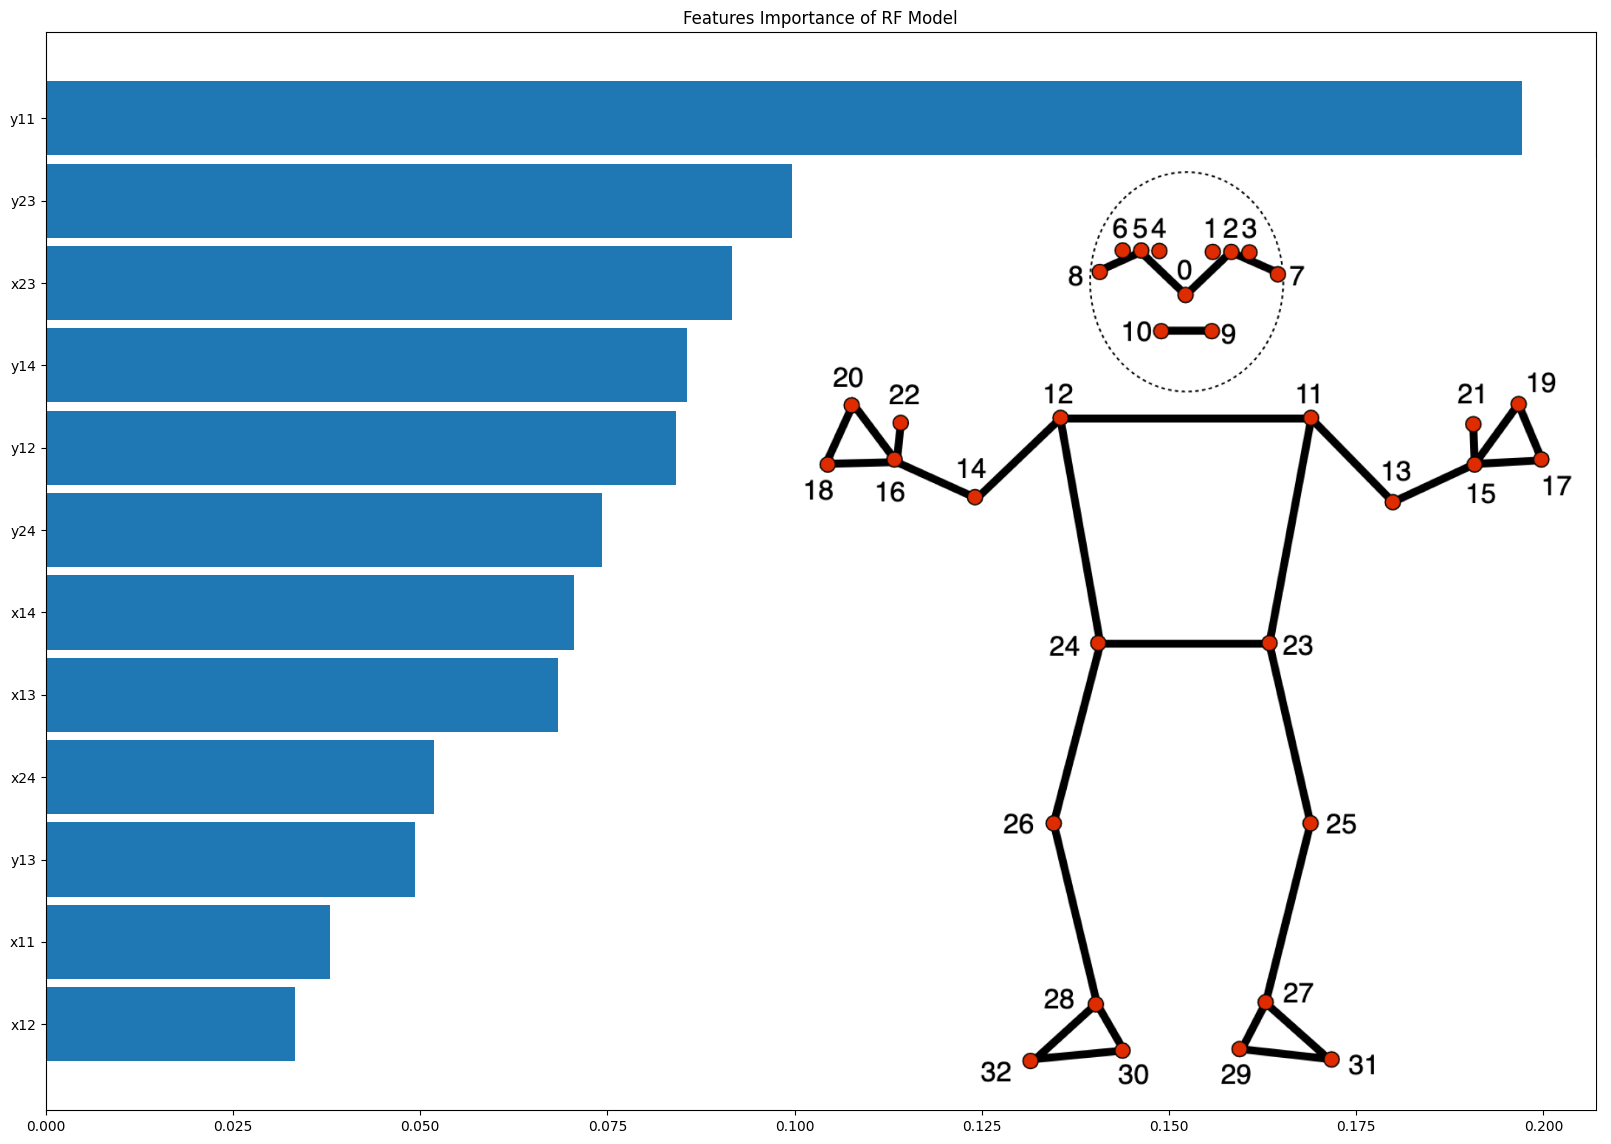

In [27]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
from PIL import Image
ind= np.argsort(rf.feature_importances_)
fig,ax = plt.subplots(figsize=[20,14])
ax.barh(y=1*np.array(range(len(rf.feature_importances_))),width= rf.feature_importances_[ind],height=.9)
ax.set_yticks(1*np.array(range(len(rf.feature_importances_))))
ax.set_yticklabels(sub_df.columns[ind])
ax.set_title("Features Importance of RF Model")


img = Image.open("pose_landmarks_index.png")  # Replace with your file path

# Use OffsetImage and AnnotationBbox to place it
imagebox = OffsetImage(img, zoom=0.4)  # adjust zoom as needed
ab = AnnotationBbox(imagebox, (1, 0),  # x=1, y=0 in axes coords
                    xycoords='axes fraction',
                    frameon=False,
                    box_alignment=(1,0))  # align bottom-right
ax.add_artist(ab)


plt.show()

In [38]:
with open('model.pkl', 'wb') as file:  # 'wb' = write binary
    pickle.dump(rf, file)

# Live Feed Push-Up Counter

In [1]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def extract_landmarks(landmarks):
    return np.array([[l.x, l.y] for l in landmarks],dtype=np.float32)

In [2]:
import cv2
import mediapipe as mp
import pickle
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

cap = cv2.VideoCapture(0)  # Open webcam
with open("model.pkl", "rb") as f:
    model = pickle.load(f)
counter = 0
prediction_n_1 = 1 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Flip for a mirror view
        frame = cv2.flip(frame, 1)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Make predictions
        results = holistic.process(rgb_frame)
        if results.pose_landmarks is not None:
            features = extract_landmarks(results.pose_landmarks.landmark).reshape(1, -1)

            # Predict using the pre-trained ML model
            prediction = model.predict(features)[0]
            if prediction != prediction_n_1:
                counter += 1
                prediction_n_1 = prediction
         

        # Display prediction
        cv2.putText(frame, f'Push-Up(s): {int(counter/2)}', (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        cv2.imshow("Webcam Feed", frame)

        if cv2.waitKey(1) & 0xFF == 27:  # ESC to quit
            break

cap.release()
cv2.destroyAllWindows()


c:\Users\mehdi\anaconda3\envs\ACV\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\mehdi\anaconda3\envs\ACV\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\mehdi\anaconda3\envs\ACV\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\mehdi\anaconda3\envs\ACV\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\mehdi\anaconda3\envs\ACV\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifi

## With FIre Emoji

In [15]:
fire_img = cv2.imread("fire.png", cv2.IMREAD_UNCHANGED)  # RGBA
def resize_fire(fire_img, counter, min_size=20, max_size=600):
    scale = min(max(counter / 1, 1), max_size / min_size)
    size = int(min_size * scale)

    resized = cv2.resize(fire_img, (size, size), interpolation=cv2.INTER_AREA)
    return resized
def overlay_image(frame, overlay, x, y):
    h, w = overlay.shape[:2]

    if y + h > frame.shape[0] or x + w > frame.shape[1]:
        return frame

    alpha = overlay[:, :, 3] / 255.0
    for c in range(3):
        frame[y:y+h, x:x+w, c] = (
            alpha * overlay[:, :, c] +
            (1 - alpha) * frame[y:y+h, x:x+w, c]
        )

    return frame


In [18]:
import cv2
import mediapipe as mp
import pickle
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

cap = cv2.VideoCapture(0)  # Open webcam
with open("model.pkl", "rb") as f:
    model = pickle.load(f)
counter = 0
prediction_n_1 = 1 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Flip for a mirror view
        frame = cv2.flip(frame, 1)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Make predictions
        results = holistic.process(rgb_frame)
        if results.pose_landmarks is not None:
            features = extract_landmarks(results.pose_landmarks.landmark).reshape(1, -1)

            # Predict using the pre-trained ML model
            prediction = model.predict(features)[0]
            if prediction != prediction_n_1:
                counter += 1
                prediction_n_1 = prediction
         

        # Display prediction
        fire_resized = resize_fire(fire_img, int(counter/2))

        frame = overlay_image(frame, fire_resized, x=10, y=50)
        cv2.putText(frame, f'Push-Up(s): {int(counter/2)}', (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        cv2.imshow("Webcam Feed", frame)

        if cv2.waitKey(1) & 0xFF == 27:  # ESC to quit
            break

cap.release()
cv2.destroyAllWindows()


c:\Users\mehdi\anaconda3\envs\ACV\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\mehdi\anaconda3\envs\ACV\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\mehdi\anaconda3\envs\ACV\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\mehdi\anaconda3\envs\ACV\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\mehdi\anaconda3\envs\ACV\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifi